## Word2Vec Approach

In [1]:
import collections
import re
import string
import unicodedata
import csv
import random

import gensim
import keras_tuner
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from keras.activations import relu, tanh, sigmoid, linear, gelu
from keras.layers import (Bidirectional, Dense, Dropout, Embedding, GRU, LSTM,
RNN)
from keras.models import Sequential
from keras.preprocessing import sequence, text
from keras.wrappers.scikit_learn import KerasClassifier
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
ExtraTreesClassifier, GradientBoostingClassifier,
RandomForestClassifier)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from xgboost import XGBClassifier

nltk.download('stopwords')

2023-04-08 10:52:53.586572: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-08 10:52:53.590650: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 10:52:53.638835: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 10:52:53.641086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 10:52:54.657263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

True

## Preprocessing

In [2]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
#article URLs not needed
df.drop(columns=['article_link'], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
#display line with most words
print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))
#delete headlines with more than 40 words
df = df[df['headline'].str.split().apply(len) < 40]
#remove Stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

print(df['headline'].str.split().apply(len).sort_values(ascending=False).head(2))
#applay length of longest headline a variable
max_len = df['headline'].str.split().apply(len).sort_values(ascending=False).head(1).values[0]

7302     151
24815     39
Name: headline, dtype: int64
24815    39
23598    38
Name: headline, dtype: int64


In [3]:
df.head()
#get number of diffrent words in headlines
words = []
for headline in df['headline']:
    for word in headline.split():
        words.append(word)
print(len(set(words)))


38212


In [4]:
#kudos https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy#LOADING-THE-DATASET
#remove square brackets, URLs and Noise

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing numbers as it can cause additional noise
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

#Removing the noisy text 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    text = remove_numbers(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

/home/rusconbenito@edu.local/anaconda3/envs/NLP/lib/python3.11/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [5]:
#converting text to format acceptable by gensim

words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

## Word2Vec Model

In [6]:

#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words, window = 5, min_count = 1)
w2v_model.wv.vectors.shape




(37034, 100)

In [7]:
tokenizer = text.Tokenizer(num_words=40000)
tokenizer.fit_on_texts(words)
#tokenized_train = tokenizer.texts_to_sequences(words)
#x = sequence.pad_sequences(tokenized_train, maxlen = 20)
sequences = tokenizer.texts_to_sequences(words)
#max_len changed to the longest headline
padded_sequences = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [8]:
padded_sequences

array([[    0,     0,     0, ...,  2307,   552,   930],
       [    0,     0,     0, ..., 11228,  1972,  1787],
       [    0,     0,     0, ..., 16405,   471,  1339],
       ...,
       [    0,     0,     0, ...,   942,   662,  1633],
       [    0,     0,     0, ..., 37034,   811,  5884],
       [    0,     0,     0, ...,  2940,   171,    92]], dtype=int32)

In [9]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [10]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


### Training Word2Vec model

In [11]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df.is_sarcastic , test_size = 0.2 , random_state = 187) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25 , random_state = 187)

In [ ]:

# Define the model architecture
# Refactoring of Dennis Code with CHATGPT
def build_model(hp):
    model = keras.Sequential()

    model.add(layers.Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

    prev_units = hp.Int("prev_units", min_value=8, max_value=96, step=2, default=96)

    for i in range(hp.Int("num_layers", 1, 3)):
        for layer_type in [LSTM, GRU]:
            curr_units = hp.Int(f"units_{i}", min_value=8, max_value=prev_units, step=2)
            prev_units = curr_units

            model.add(Bidirectional(layer_type(units=curr_units,
                                               recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.8, step=0.1),
                                               dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.8, step=0.1),
                                               activation=hp.Choice(f"activation_{i}", values=["relu", "tanh", "gelu"]),
                                               return_sequences=True),
                                               name=f"bidirectional_{layer_type.__name__.lower()}_{i}"))

    learning_rate_tuned = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.add(layers.Dense(1, activation="sigmoid", name="output"))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuned),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    return model







In [ ]:
#helper class so callback works with tuner (ChatGPT)
class TerminationOnNoImprovement(keras.callbacks.Callback):
    def __init__(self, patience=10, restore_best_weights=True):
        super(TerminationOnNoImprovement, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_epoch = None
        self.best_val_acc = None

    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()
        self.best_epoch = 0
        self.best_val_acc = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc > self.best_val_acc:
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            self.best_val_acc = val_acc
        elif epoch - self.best_epoch >= self.patience:
            print(f'Epoch {epoch}: early stopping')
            self.model.stop_training = True
            if self.restore_best_weights:
                print(f'Restored model weights from epoch {self.best_epoch}')
                self.model.set_weights(self.best_weights)




In [ ]:
tuner = RandomSearch(
    build_model, objective='val_accuracy',
    max_trials=100, executions_per_trial=1,
    directory='Tuner',project_name='NLP_Tuner',seed=187
)

batch_sizes = [16,32, 64, 128, 256,512,1024,2048]


best_batch_size = None; best_model = None; best_hparams = None; best_val_acc = -float('inf')

for _ in range(len(batch_sizes)):
    #batch_size = random.choice(batch_sizes)
    #print(f'Batch size: {batch_size}')
    tuner.search(x_train, y_train, epochs=50, validation_data=(x_val, y_val), batch_size=128, callbacks=[TerminationOnNoImprovement()])
    trial_best_model = tuner.get_best_models(num_models=1)[0]
    trial_best_hparams = tuner.get_best_hyperparameters(num_trials=1)[0]
    trial_best_val_acc = tuner.get_best_trial('val_accuracy').score

    if trial_best_val_acc > best_val_acc:
        best_batch_size = batch_size
        best_model = trial_best_model
        best_hparams = trial_best_hparams
        best_val_acc = trial_best_val_acc
        #write best model to file
        best_model.save('best_model.h5')
        #write best hyperparameters to file
        with open('best_hparams.json', 'w') as f:
            json.dump(best_hparams.values, f)
            

print(f'Best batch size: {best_batch_size}')
print(f'Best validation accuracy: {best_val_acc}')
print(f'Best hyperparameters: {best_hparams.values}')




INFO:tensorflow:Reloading Tuner from Tuner/NLP_Tuner/tuner0.json

Search: Running Trial #32

Value             |Best Value So Far |Hyperparameter
38                |22                |prev_units
3                 |2                 |num_layers
58                |60                |units_0
0.2               |0.4               |recurrent_dropout_0
0.5               |0.7               |dropout_0
tanh              |tanh              |activation_0
0.0066263         |0.00010899        |lr
8                 |16                |units_1
0.8               |0.6               |recurrent_dropout_1
0                 |0.8               |dropout_1
tanh              |tanh              |activation_1
8                 |8                 |units_2
0.8               |0.4               |recurrent_dropout_2
0.8               |0.6               |dropout_2
tanh              |gelu              |activation_2



2023-04-08 10:53:00.890755: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Flatten
from tensorflow.keras.models import Sequential
#best model after 50 first trials
#best val_accuracy 80.08%
'''Value             |Best Value So Far |Hyperparameter
    38                |22                |prev_units
    3                 |2                 |num_layers
    58                |60                |units_0
    0.2               |0.4               |recurrent_dropout_0
    0.5               |0.7               |dropout_0
    tanh              |tanh              |activation_0
    0.0066263         |0.00010899        |lr
    8                 |16                |units_1
    0.8               |0.6               |recurrent_dropout_1
    0                 |0.8               |dropout_1
    tanh              |tanh              |activation_1
    8                 |8                 |units_2
    0.8               |0.4               |recurrent_dropout_2
    0.8               |0.6               |dropout_2
    tanh              |gelu              |activation_2'''
# Defining Neural Network
model = Sequential()

# Non-trainable embedding layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], trainable=True))

# LSTM 
model.add(Bidirectional(LSTM(units=60, activation='tanh', recurrent_dropout=0.4, dropout=0.7, return_sequences=True)))
model.add(Bidirectional(GRU(units= 16, activation='tanh', recurrent_dropout=0.6, dropout=0.8, return_sequences=True)))

# Output layer
model.add(Dense(1, activation='tanh'))
#model.add(Flatten())  # Convert 2D tensor to 1D tensor
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00010899), loss='binary_crossentropy', metrics=['acc'])



In [24]:

#early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_val,y_val) , epochs = 1000, callbacks=[early_stopping])



Epoch 1/1000
134/134 [==============================] - 15s 110ms/step - loss: 0.1796 - acc: 0.9372 - val_loss: 0.6184 - val_acc: 0.7940
Epoch 2/1000
134/134 [==============================] - 15s 111ms/step - loss: 0.1673 - acc: 0.9432 - val_loss: 0.6197 - val_acc: 0.7928
Epoch 3/1000
134/134 [==============================] - 15s 110ms/step - loss: 0.1617 - acc: 0.9452 - val_loss: 0.6765 - val_acc: 0.7956
Epoch 4/1000
134/134 [==============================] - 15s 110ms/step - loss: 0.1492 - acc: 0.9512 - val_loss: 0.7261 - val_acc: 0.7976
Epoch 5/1000
134/134 [==============================] - ETA: 0s - loss: 0.1408 - acc: 0.9531

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_val,y_val)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

535/535 [==============================] - 13s 25ms/step - loss: 0.1038 - acc: 0.9649
Accuracy of the model on Training Data is -  96.49026989936829
179/179 [==============================] - 5s 25ms/step - loss: 0.6230 - acc: 0.7961
Accuracy of the model on Testing Data is -  79.6122133731842


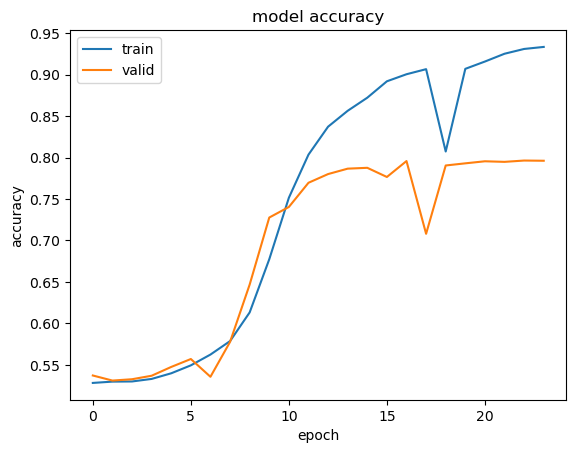

In [ ]:
#plot accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


## Maschine Learning

In [ ]:
#CHTGPT

# Define the models to be compared
models = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression(random_state=187, max_iter=10000)),
    ('Decision Tree', DecisionTreeClassifier(random_state=187)),
    ('Random Forest', RandomForestClassifier(random_state=187)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=187)),
    ('XGBoost', XGBClassifier(random_state=187)),
    ('LightGBM', LGBMClassifier(random_state=187)),
    ('MLP', MLPClassifier(random_state=187)),
    ('SVM', SVC(random_state=187)),
    ('AdaBoost', AdaBoostClassifier(random_state=187)),
    ('Bagging', BaggingClassifier(random_state=187)),
    ('ExtraTrees', ExtraTreesClassifier(random_state=187)),
    ('NuSVC', NuSVC(random_state=187)),  
    ('PassiveAggressive', PassiveAggressiveClassifier(random_state=187)),
    ('MultinomialNB', MultinomialNB())    
                  
]


# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])

# Evaluate the models using 5-fold cross-validation
kfold = KFold(n_splits=5, random_state=187, shuffle=True)
for name, model in models:
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    train_score = cv_results.mean()
    validation_score = model.fit(x_train, y_train).score(x_val, y_val)
    test_score = model.fit(x_train, y_train).score(x_test, y_test)
    results_df = pd.concat([results_df, pd.DataFrame([[name, train_score, validation_score, test_score]], 
                                                      columns=['Model', 'Train Score', 'Validation Score', 'Test Score'])], 
                            ignore_index=True)
    print(f"{name}: Train Score: {train_score:.2f}, Validation Score: {validation_score:.2f}, Test Score: {test_score:.2f}")

# Print the results dataframe
print(results_df)


NameError: name 'KNeighborsClassifier' is not defined

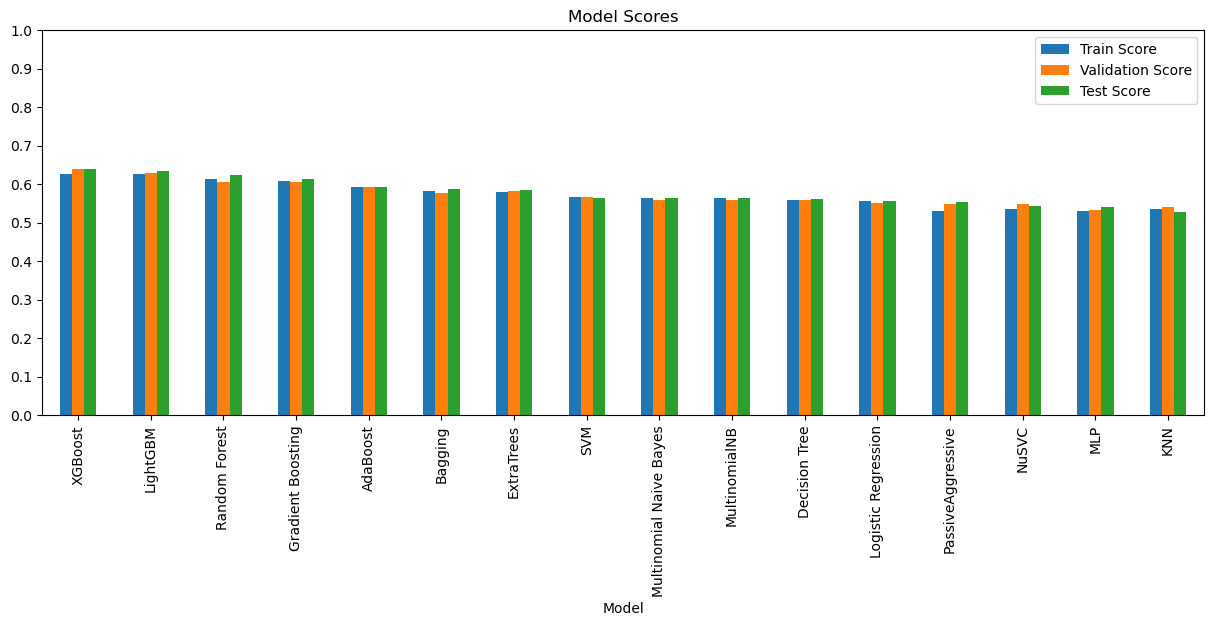

In [ ]:
#bar chart of results_df sort by test score
results_df.sort_values(by='Test Score', ascending=False).plot(x='Model', y=['Train Score', 'Validation Score', 'Test Score'], kind='bar', figsize=(15, 5), title='Model Scores')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.show()


